# Testing different techniques to work with unequal classes

## The Problem:
As we tried to classify, if the datapoints into the covid19 datasets is wether a deathcase or not, we found out that the created model did not perform so well as we wanted. 

The prediction of "No Deathcase"-Class worked pretty well and we got a precision of 0.97 and a f1-score of 0.98 for 54590 provided test samples of the class.
The second class (the "Deathcase"-Class) worked not so well, the precision was 0.42 and the f1-score was only 0.05 for 1872 test samples.

### Unequal classes
As shown above the classes are not equal provided. For the Train-Test-Split we used the build-in function from scikit-learn were we used 20% as the test-split so the percentage of deathcases in the whole dataset is 3% which is also the percentage in the test-split.

<AxesSubplot:title={'center':'Percentage of Deathcases in the whole covid-19 dataset'}, xlabel='Deathcase', ylabel='count'>

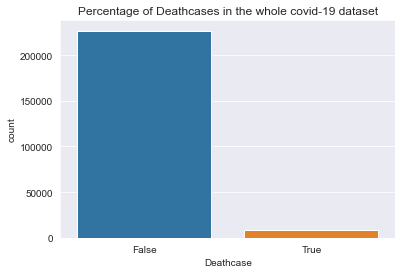

In [1]:
import modules.DataLoader as DataLoader

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

covid19, features = DataLoader.load_covid19_for_deathcase()

plt.title("Percentage of Deathcases in the whole covid-19 dataset")
sns.countplot(x="Deathcase", data=covid19)

# Techniques to work with unequal classes in classification

In the following code-snippets ee are testing five different techniques to increase the performance of our binary classification on the covid19 dataset by using:

1. Upsampling of the Minority Class
2. Downsampling of the Majority Class
3. Changing the Performance Metric
4. Using Penalizing Algorithms
5. Tree-based Algorithms

The idea of using these techniques comes from a blog-post from: [https://elitedatascience.com/imbalanced-classes](https://elitedatascience.com/imbalanced-classes)

## The Model
For the test of the five approaches we will define a model to use this in the most of the approaches. We will use the same features and transformations of the data as we did in the first approach of the model so we can compare them.

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

num_transformer = Pipeline([
    ("scaler", StandardScaler())
])

cat_transfomer = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, ["Altersgruppe"]),
    ("cat", cat_transfomer, ["Bundesland", "Landkreis", "Geschlecht"])
])

model = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression())
])

## Train-Test-Split
We will also take the same Train-Test-Split as before

In [3]:
from sklearn.model_selection import train_test_split

covid19, features = DataLoader.load_covid19_for_deathcase(cleaned=True)

X_train, X_test, y_train, y_test = train_test_split(
    covid19[features[:-2]], 
    covid19[features[-1]],
    test_size=0.2,
    random_state=42)

print("  Training-Data :")
print("\tX_train : ", X_train.shape)
print("\ty_train : ", y_train.shape)
print("\n   Testing-Data :")
print("\tX_test  : ", X_test.shape)
print("\ty_test  : ", y_test.shape)

  Training-Data :
	X_train :  (187304, 4)
	y_train :  (187304,)

   Testing-Data :
	X_test  :  (46827, 4)
	y_test  :  (46827,)


## 1. Upsampling of the Minority Class
### The Idea:
We will try to randomly duplicate datapoints from the minority class to amplify its signal for the model. For this approach we will use the "resample"-Utility that is build-in scikit-learn and orient our code on the work from [https://elitedatascience.com/imbalanced-classes](https://elitedatascience.com/imbalanced-classes).

Deathcases:	 6879
No Deathcases:	 180425

Upsampling ...
Deathcases upsampled:  180425

Training model ...
Shape of data:  (360850, 4)
Accuracy: 0.86 (+/- 0.00)
Balanced Accuracy: 0.86 (+/- 0.00)

Predicting ...
Accuracy: 0.84
              precision    recall  f1-score   support

       False       0.99      0.83      0.91     45056
        True       0.17      0.88      0.29      1771

    accuracy                           0.84     46827
   macro avg       0.58      0.86      0.60     46827
weighted avg       0.96      0.84      0.88     46827



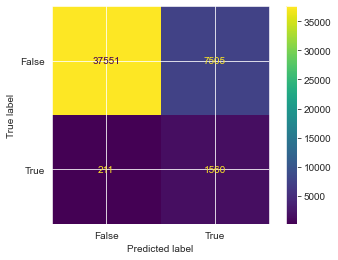

In [16]:
import pandas as pd
from copy import deepcopy
from sklearn import clone
from sklearn.utils import resample
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

# First save the X_train and y_train data into separate DataFrames
X_train_up, y_train_up = X_train, y_train

# Then put all the columns together and generate a overall training set
train_up = X_train_up
train_up[features[-1]] = y_train_up

# Separate the classes into two separate DataFrames
# Where features[-1] is the columnname of the label data
covid19_deathcase_up = train_up[train_up[features[-1]] == True]
covid19_no_deathcase_up = train_up[train_up[features[-1]] == False]

print("Deathcases:\t", covid19_deathcase_up.count()[0])
print("No Deathcases:\t", covid19_no_deathcase_up.count()[0])

# Doing the Upsampling
print("\nUpsampling ...")
covid19_deathcase_upsampled = resample(covid19_deathcase_up, 
                                  replace=True, 
                                  n_samples=covid19_no_deathcase_up.count()[0],
                                  random_state=42)

print("Deathcases upsampled: ", covid19_deathcase_upsampled.count()[0])

# Now lets bring the data the classes together and shuffle them again
train_up = pd.concat([covid19_no_deathcase_up, covid19_deathcase_upsampled])
train_up = train_up.sample(frac=1).reset_index(drop=True)

# Now Split the label- from the feature-columns
X_train_up = train_up[features[:-2]]
y_train_up = train_up[features[-1]]

# And train model
print("\nTraining model ...")
print("Shape of data: ", X_train_up.shape)

model_up = clone(model)

scores = cross_val_score(model_up, X_train_up, y_train_up, cv=5, n_jobs=12, scoring="accuracy")

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

b_scores = cross_val_score(model_up, X_train_up, y_train_up, cv=5, n_jobs=12, scoring="balanced_accuracy")
print("Balanced Accuracy: %0.2f (+/- %0.2f)" % (b_scores.mean(), b_scores.std() * 2))

model_up.fit(X_train_up, y_train_up)

# And predicting on the test dataset
print("\nPredicting ...")
y_pred_up = model_up.predict(X_test)

print("Accuracy: {0:.2f}".format(accuracy_score(y_pred=y_pred_up, y_true=y_test)))
print(classification_report(y_test, y_pred_up))
plot_confusion_matrix(model_up, X_test, y_test)

## 2. Downsampling of the Majority Class
### The Idea:
We will try to randomly removing datapoints from the majority class to prevent that its signal is dominating the model. For this approach we will use the "resample"-Utility too and orient our code again on the work from [https://elitedatascience.com/imbalanced-classes](https://elitedatascience.com/imbalanced-classes).

Deathcases:	 6879
No Deathcases:	 180425

Downsampling ...
No Deathcases downsampled:  6879

Training model ...
Shape of data:  (13758, 4)
Accuracy: 0.85 (+/- 0.01)

Predicting ...
Accuracy: 0.83
              precision    recall  f1-score   support

       False       1.00      0.83      0.90     45056
        True       0.17      0.90      0.29      1771

    accuracy                           0.83     46827
   macro avg       0.58      0.86      0.60     46827
weighted avg       0.96      0.83      0.88     46827



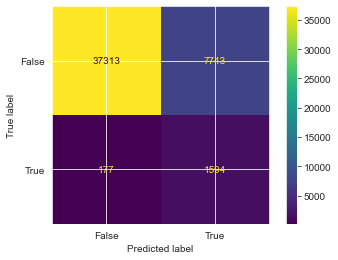

In [17]:
# First save the X_train and y_train data into separate DataFrames
X_train_down, y_train_down = X_train, y_train

# Then put all the columns together and generate a overall training set
train_down = X_train_down
train_down[features[-1]] = y_train_down

# Separate the classes into two separate DataFrames
# Where features[-1] is the columnname of the label data
covid19_deathcase_down = train_down[train_down[features[-1]] == True]
covid19_no_deathcase_down = train_down[train_down[features[-1]] == False]

print("Deathcases:\t", covid19_deathcase_down.count()[0])
print("No Deathcases:\t", covid19_no_deathcase_down.count()[0])

# Doing the Upsampling
print("\nDownsampling ...")
covid19_deathcase_downsampled = resample(covid19_no_deathcase_down, 
                                  replace=True, 
                                  n_samples=covid19_deathcase_down.count()[0],
                                  random_state=42)

print("No Deathcases downsampled: ", covid19_deathcase_downsampled.count()[0])

# Now lets bring the data the classes together and shuffle them again
train_down = pd.concat([covid19_deathcase_down, covid19_deathcase_downsampled])
train_down = train_down.sample(frac=1).reset_index(drop=True)

# Now Split the label- from the feature-columns
X_train_down = train_down[features[:-2]]
y_train_down= train_down[features[-1]]

# And train model
print("\nTraining model ...")
print("Shape of data: ", X_train_down.shape)

model_down = clone(model)

scores = cross_val_score(model_down, X_train_down, y_train_down, cv=5, n_jobs=12, scoring="balanced_accuracy")

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

model_down.fit(X_train_down, y_train_down)

# And predicting on the test dataset
print("\nPredicting ...")
y_pred_down = model_down.predict(X_test)

print("Accuracy: {0:.2f}".format(accuracy_score(y_pred=y_pred_down, y_true=y_test)))
print(classification_report(y_test, y_pred_down))
plot_confusion_matrix(model_down, X_test, y_test)

## 3. Changing the Performance Metric
### The Idea:
We will try to use different Performance-Metrics to evaluate our classifiers. For this approach wie will use the so called Reciever Operating Characterisitc (ROC) Curve and the Precision Recall (PR) Curve.

The idea is on the work from [https://elitedatascience.com/imbalanced-classes](https://elitedatascience.com/imbalanced-classes).

ROC-Curve is plotted by using the Sensitivity (True-Positive-Rate, Hit-Rate or Recall) as y-axis and the Specificity (False-Positive-Rate) as x-axis.

$$ \text{True-Positive-Rate}=TPR=\frac{TP}{TP + FN}$$ 
$$ \text{False-Positive-Rate}=FPR=\frac{TN}{TN+FP}$$

PR-Curve is plotted by using the Precision (Postive-Predictive-Value) on the y-axis and the Sensitivity (True-Positive-Rate, Hit-Rate or Recall) on the x-axis.

$$ \text{Postive-Predictive-Value}=PPV=\frac{TP}{TP + FP}$$ 

Our Approach will test how the two metrics will rate our classifiers:

1. A Std. Classifier without the resampling, so that the classes are unequal trained.

2. Upsampling Approach.

3. Downsampling Approach.
 
SAITO, Takaya; REHMSMEIER, Marc. The precision-recall plot is more informative than the ROC plot when evaluating binary classifiers on imbalanced datasets. PloS one, 2015, 10. Jg., Nr. 3, S. e0118432. https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0118432#sec026.

### 3.1 Build the Std. Classifier and testing the ROC- and RP-Curve


Training model ...
Shape of data:  (187304, 4)

Predicting ...
Accuracy: 0.86 (+/- 0.00)
Accuracy: 0.96
              precision    recall  f1-score   support

       False       0.96      1.00      0.98     45056
        True       0.49      0.03      0.06      1771

    accuracy                           0.96     46827
   macro avg       0.73      0.52      0.52     46827
weighted avg       0.95      0.96      0.95     46827



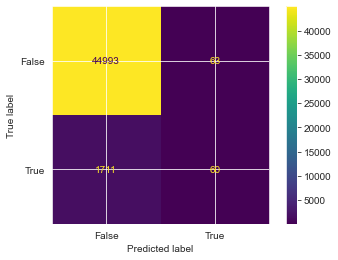

In [6]:
X_train_std, y_train_std = X_train, y_train
model_std = clone(model)

print("\nTraining model ...")
print("Shape of data: ", X_train_std[["Bundesland", "Landkreis", "Altersgruppe", "Geschlecht"]].shape)
model_std.fit(X_train_std[["Bundesland", "Landkreis", "Altersgruppe", "Geschlecht"]], y_train_std)

# And predicting on the test dataset
print("\nPredicting ...")
y_pred_std = model_std.predict(X_test)

scores = cross_val_score(model_up, X_train_up, y_train_up, cv=5, n_jobs=12, scoring="balanced_accuracy")

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print("Accuracy: {0:.2f}".format(accuracy_score(y_pred=y_pred_std, y_true=y_test)))
print(classification_report(y_test, y_pred_std))
plot_confusion_matrix(model_std, X_test, y_test)

Text(0.5, 1.0, 'ROC-Curves')

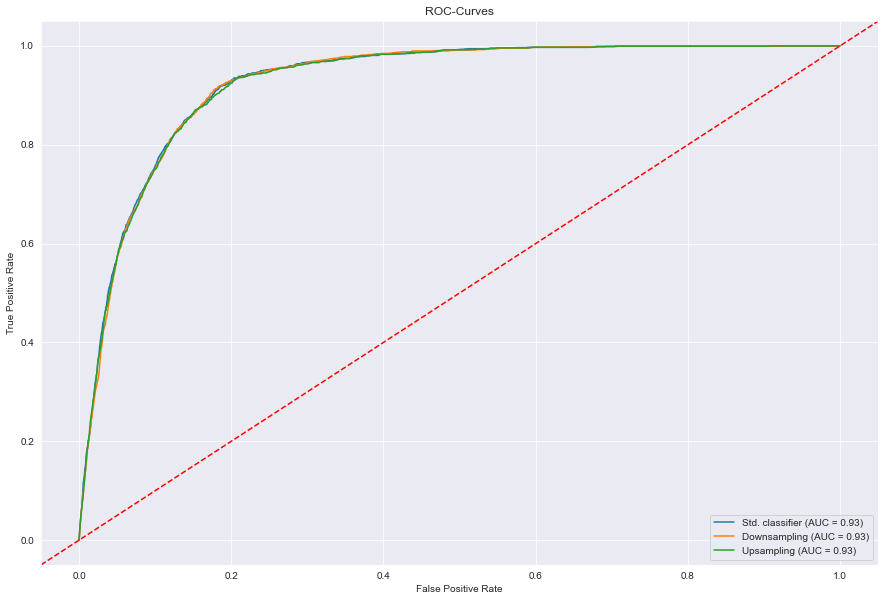

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve

y_prob_std = model_std.predict_proba(X_test)
y_prob_std = y_prob_std[:, 1]

plot_roc_curve(model_std, X_test, y_test, ax=plt.gca(), name="Std. classifier", )
plot_roc_curve(model_down, X_test, y_test, ax=plt.gca(), name="Downsampling")
plot_roc_curve(model_up, X_test, y_test, ax=plt.gca(), name="Upsampling")

plt.axline((0, 0), slope=1, color="red", linestyle="--")

fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.title("ROC-Curves")

Text(0.5, 1.0, 'RP-Curves')

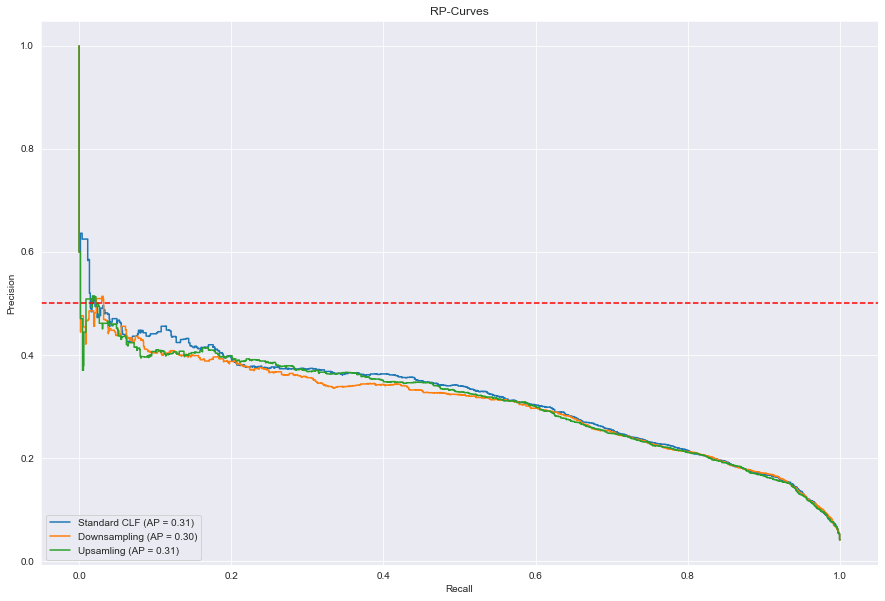

In [8]:
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(model_std, X_test, y_test, ax=plt.gca(), name="Standard CLF")
plot_precision_recall_curve(model_down, X_test, y_test, ax= plt.gca(), name="Downsampling")
plot_precision_recall_curve(model_up, X_test, y_test, ax=plt.gca(), name="Upsamling")

plt.axhline(y=0.5, color="red", linestyle='--', label='No Skill')

fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.title("RP-Curves")

## 4. Penalize Algorithms 


Training model ...
Shape of data:  (187304, 4)

Predicting ...
Accuracy: 0.86 (+/- 0.01)
Accuracy: 0.83
              precision    recall  f1-score   support

       False       0.99      0.83      0.91     45056
        True       0.17      0.89      0.29      1771

    accuracy                           0.83     46827
   macro avg       0.58      0.86      0.60     46827
weighted avg       0.96      0.83      0.88     46827



0.8583691433820935

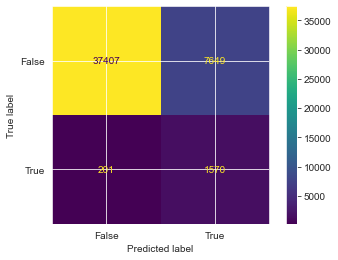

In [18]:
from sklearn.svm import LinearSVC
from sklearn.metrics import balanced_accuracy_score

X_train_pen, y_train_pen = X_train, y_train

model_pen = Pipeline([
    ("pre", preprocessor),
    ("clf", LinearSVC(class_weight='balanced', ))
])

print("\nTraining model ...")
print("Shape of data: ", X_train_pen[["Bundesland", "Landkreis", "Altersgruppe", "Geschlecht"]].shape)
model_pen.fit(X_train_pen[["Bundesland", "Landkreis", "Altersgruppe", "Geschlecht"]], y_train_pen)

# And predicting on the test dataset
print("\nPredicting ...")
y_pred_pen = model_pen.predict(X_test)

scores = cross_val_score(model_pen, X_train_pen, y_train_pen, cv=5, n_jobs=12, scoring="balanced_accuracy")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print("Accuracy: {0:.2f}".format(accuracy_score(y_pred=y_pred_pen, y_true=y_test)))
print(classification_report(y_test, y_pred_pen))
plot_confusion_matrix(model_pen, X_test, y_test)

# HEFTIG!
balanced_accuracy_score(y_test, y_pred_pen)

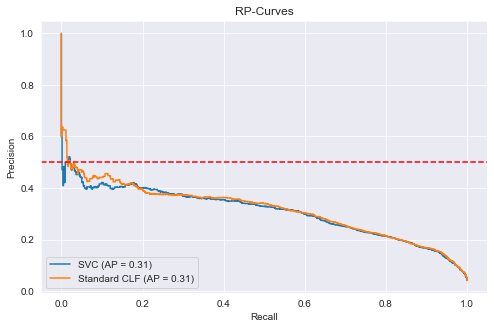

Text(0.5, 1.0, 'ROC-Curves')

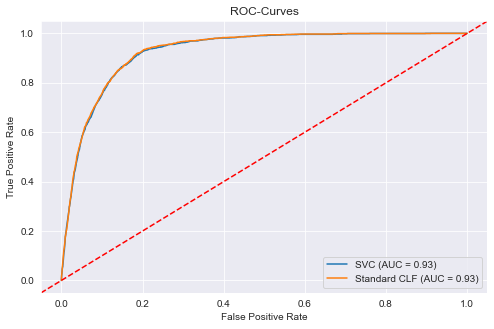

In [10]:
from sklearn.metrics import plot_roc_curve

plot_precision_recall_curve(model_pen, X_test, y_test, ax=plt.gca(), name="SVC")
plot_precision_recall_curve(model_std, X_test, y_test, ax=plt.gca(), name="Standard CLF")

plt.axhline(y=0.5, color="red", linestyle='--', label='No Skill')

fig = plt.gcf()
fig.set_size_inches(8,5)
plt.title("RP-Curves")

plt.show()

plot_roc_curve(model_pen, X_test, y_test, ax=plt.gca(), name="SVC")
plot_roc_curve(model_std, X_test, y_test, ax=plt.gca(), name="Standard CLF")

plt.axline((0, 0), slope=1, color="red", linestyle="--")

fig = plt.gcf()
fig.set_size_inches(8,5)
plt.title("ROC-Curves")


## 5. Using Tree-Based Algorithms

Accuracy: 0.52 (+/- 0.01)

Training model ...
Shape of data:  (187304, 4)

Predicting ...
Accuracy: 0.96
              precision    recall  f1-score   support

       False       0.96      1.00      0.98     45056
        True       0.42      0.05      0.09      1771

    accuracy                           0.96     46827
   macro avg       0.69      0.52      0.53     46827
weighted avg       0.94      0.96      0.95     46827



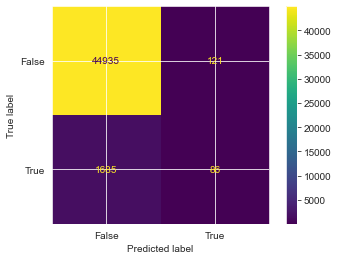

In [19]:
from sklearn.ensemble import RandomForestClassifier

X_train_tree, y_train_tree = X_train, y_train

model_tree = Pipeline([
    ("pre", preprocessor),
    ("clf", RandomForestClassifier())
])

scores = cross_val_score(model_tree, X_train_tree, y_train_tree, cv=5, n_jobs=12, scoring="balanced_accuracy")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print("\nTraining model ...")
print("Shape of data: ", X_train_tree[["Bundesland", "Landkreis", "Altersgruppe", "Geschlecht"]].shape)
model_tree.fit(X_train_tree[["Bundesland", "Landkreis", "Altersgruppe", "Geschlecht"]], y_train_tree)

# And predicting on the test dataset
print("\nPredicting ...")
y_pred_tree = model_tree.predict(X_test)

print("Accuracy: {0:.2f}".format(accuracy_score(y_pred=y_pred_tree, y_true=y_test)))
print(classification_report(y_test, y_pred_tree))
plot_confusion_matrix(model_tree, X_test, y_test)

In [ ]:
plot_precision_recall_curve(model_tree, X_test, y_test, ax=plt.gca(), name="RandomForest")
plot_precision_recall_curve(model_std, X_test, y_test, ax=plt.gca(), name="Standard CLF")

plt.axhline(y=0.5, color="red", linestyle='--', label='No Skill')

fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.title("RP-Curves")